<a href="https://colab.research.google.com/github/YuranShi/george-replication/blob/main/george_replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# George Replication

**Prompt**: Deep neural networks often exploit non-predictive features that are spuriously correlated with class labels, leading to poor performance on groups of examples without such features. Using the SpuCo Package ([SpuCo Documentation](https://spuco.readthedocs.io/en/latest/)), we'd like you to implement a simple method to remedy spurious correlations in [SpuCoMNIST](https://spuco.readthedocs.io/en/latest/reference/datasets.html#spuco.datasets.spuco_mnist.SpuCoMNIST) (use default parameters to initialize the dataset).

The method ([George](https://arxiv.org/abs/2011.12945)) we'd like you to implement has a 3 step pipeline:
1. Train a model using ERM
2. Cluster inputs based on the output they produce for ERM
3. Retrain using "Group-Balancing" to ensure in each batch each group appears equally.

We'd like you to send us a notebook with your code and outputs (similar to the [SpuCo Quickstart Notebooks](https://github.com/BigML-CS-UCLA/SpuCo/tree/master/quickstart/spuco_mnist)).

## 0. Load and Explore SpuCoMNIST Dataset


In [1]:
# Install spuco package and mute the output
%pip install spuco --upgrade > /dev/null 2>&1

### 0.1 Load SpuCoMNIST Dataset

In [2]:
import torch
from torch.optim import SGD

import matplotlib.pyplot as plt

from spuco.datasets import SpuCoMNIST, SpuriousFeatureDifficulty
from spuco.models import model_factory
from spuco.robust_train import ERM
from spuco.evaluate import Evaluator
from spuco.group_inference import Cluster, ClusterAlg
from spuco.robust_train import GroupBalanceBatchERM

In [52]:
classes = [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]
difficulty = SpuriousFeatureDifficulty.MAGNITUDE_LARGE

train_set = SpuCoMNIST(
    root="./data",
    spurious_feature_difficulty=difficulty,
    spurious_correlation_strength=0.995,
    classes=classes,
    split="train",
    verbose=True
)
train_set.initialize()

test_set = SpuCoMNIST(
    root="./data",
    spurious_feature_difficulty=difficulty,
    classes=classes,
    split="test",
    verbose=True
)
test_set.initialize()

Adding spurious feature: 100%|██████████| 5/5 [00:00<00:00,  5.32it/s]


In [53]:
# Validate train_set and test_set classes
print(train_set.validate_classes(classes))
print(test_set.validate_classes(classes))

True
True


In [54]:
# Check the length of training and testing set
len(train_set), len(test_set)

(48004, 10000)

### 0.2 Visualize SpuCoMNIST Dataset

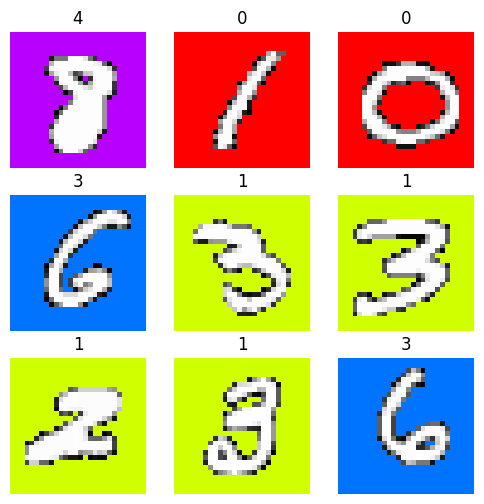

In [55]:
# Visualize MNIST data by random selecting images from SpuCoMNIST Dataset
torch.manual_seed(42)

fig = plt.figure(figsize=(6, 6))
rows, cols = 3, 3

for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_set), size=[1]).item()
    img, label = train_set[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
    plt.title(label)

In [56]:
# Set device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Train Model with ERM

### 1.1 Train LeNet Model

In [57]:
model = model_factory("lenet", train_set[0][0].shape, train_set.num_classes).to(device)
model

SpuCoModel(
  (backbone): LeNet(
    (features): Sequential(
      (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc_1): Linear(in_features=400, out_features=120, bias=True)
    (fc_2): Linear(in_features=120, out_features=84, bias=True)
  )
  (classifier): Linear(in_features=84, out_features=5, bias=True)
)

In [58]:
BATCH_SIZE = 64
optimizer = SGD(model.parameters(), lr=1e-2, momentum=0.9, nesterov=True)

erm = ERM(
    model=model,
    num_epochs=1,
    trainset=train_set,
    batch_size=BATCH_SIZE,
    optimizer=optimizer,
    device=device,
    verbose=False
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [59]:
erm.train()

### 1.2 Evaluation

In [60]:
evaluator = Evaluator(
    testset=test_set,
    group_partition=test_set.group_partition,
    group_weights=train_set.group_weights,
    batch_size=64,
    model=model,
    device=device,
    verbose=False
)
evaluator.evaluate()

Evaluating group-wise accuracy: 100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


{(0, 0): 100.0,
 (0, 1): 0.0,
 (0, 2): 0.0,
 (0, 3): 0.0,
 (0, 4): 0.0,
 (1, 0): 0.0,
 (1, 1): 100.0,
 (1, 2): 0.0,
 (1, 3): 0.0,
 (1, 4): 0.0,
 (2, 0): 0.0,
 (2, 1): 0.0,
 (2, 2): 100.0,
 (2, 3): 0.0,
 (2, 4): 0.0,
 (3, 0): 0.0,
 (3, 1): 0.0,
 (3, 2): 0.0,
 (3, 3): 100.0,
 (3, 4): 0.0,
 (4, 0): 0.0,
 (4, 1): 0.0,
 (4, 2): 0.0,
 (4, 3): 0.0,
 (4, 4): 100.0}

In [61]:
print(f"Worst group accuracy: {evaluator.worst_group_accuracy} -> (group, accuracy)")
print(f"Average accuracy: {evaluator.average_accuracy}")
print(f"Evaluate spurious attribute prediction: {evaluator.evaluate_spurious_attribute_prediction()}")

Worst group accuracy: ((0, 1), 0.0) -> (group, accuracy)
Average accuracy: 99.49379218398467
Evaluate spurious attribute prediction: 20.4


## 2. Cluster Inputs Based on ERM Outputs


In [63]:
# Get the train output logits from trained model for clustering
model.eval()

output_logits = []

with torch.inference_mode():
  for sample, _ in train_set:
    sample = torch.unsqueeze(sample, dim=0).to(device) # Add a batch dimension
    logits = model(sample)
    output_logits.append(logits)

output_logits = torch.cat(output_logits)

In [64]:
output_logits.size()

torch.Size([48004, 5])

In [65]:
cluster = Cluster(
    Z=output_logits,
    class_labels=train_set.labels,
    cluster_alg=ClusterAlg.KMEANS,
    num_clusters=2,
    device=device,
    verbose=True
)
group_partition = cluster.infer_groups()

Clustering class-wise: 100%|██████████| 5/5 [00:00<00:00, 13.83it/s]


In [66]:
for key in sorted(group_partition.keys()):
    print(key, len(group_partition[key]))

(0, 0) 10082
(0, 1) 51
(1, 0) 9623
(1, 1) 49
(2, 0) 46
(2, 1) 8965
(3, 0) 9698
(3, 1) 49
(4, 0) 48
(4, 1) 9393


## 3. Retrain using "Group-Balancing"

In [67]:
epochs = 2

group_balance = GroupBalanceBatchERM(
    model=model,
    num_epochs=epochs,
    trainset=train_set,
    group_partition=group_partition,
    batch_size=BATCH_SIZE,
    optimizer=optimizer,
    device=device,
    verbose=False
)

group_balance.train()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [68]:
evaluator = Evaluator(
    testset=test_set,
    group_partition=test_set.group_partition,
    group_weights=train_set.group_weights,
    batch_size=64,
    model=model,
    device=device,
    verbose=False
)

evaluator.evaluate()

Evaluating group-wise accuracy: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


{(0, 0): 99.52718676122932,
 (0, 1): 95.27186761229315,
 (0, 2): 85.34278959810875,
 (0, 3): 82.74231678486997,
 (0, 4): 71.15839243498817,
 (1, 0): 90.70904645476773,
 (1, 1): 99.26650366748166,
 (1, 2): 84.80392156862744,
 (1, 3): 84.55882352941177,
 (1, 4): 74.26470588235294,
 (2, 0): 73.86666666666666,
 (2, 1): 78.13333333333334,
 (2, 2): 97.6,
 (2, 3): 54.93333333333333,
 (2, 4): 13.101604278074866,
 (3, 0): 74.12060301507537,
 (3, 1): 70.27707808564232,
 (3, 2): 79.5969773299748,
 (3, 3): 100.0,
 (3, 4): 84.88664987405542,
 (4, 0): 62.97229219143577,
 (4, 1): 46.34760705289673,
 (4, 2): 38.79093198992443,
 (4, 3): 85.85858585858585,
 (4, 4): 99.4949494949495}

In [69]:
print(f"Worst group accuracy: {evaluator.worst_group_accuracy} -> (group, accuracy)")
print(f"Average accuracy: {evaluator.average_accuracy}")
print(f"Evaluate spurious attribute prediction: {evaluator.evaluate_spurious_attribute_prediction()}")

Worst group accuracy: ((2, 4), 13.101604278074866) -> (group, accuracy)
Average accuracy: 99.0798037031593
Evaluate spurious attribute prediction: 20.58
